# Neural Networks for Eddy Covarinace

In [115]:
## Import some standard packages and define a few functions
import os
# Hide default info, logs, and warnings - comment out if you need to troubleshoot
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import shutil
import importlib
import numpy as np
import pandas as pd
# from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from Scripts import PlotHelpers
from Scripts import ReadDB, MiscFuncs, NNetFuncs


In [116]:


Vars = {'WTD_1_1_1':'Water table',
     'TA_1_1_1':'T air',
     'RH_1_1_1':'RH',
     'VPD_1_1_1':'VPD',
     'FC':'FCO2',
     'FCH4':'FCH4',
     'PPFD_IN_1_1_1':'PPFD In',
     'PPFD_OUT_1_1_1':'PPFD Out',
     'NETRAD_1_1_1':'Rn',
     'P_1_1_1':'Precip',
     'qc_co2_flux':'qc_FCO2',
     'qc_ch4_flux':'qc_FCH4',
     'USTAR':'u*',
     'TS_1':'T soil 5cm',
     'TS_2':'T soil 10cm',
     'TS_3':'T soil 50cm',
     'WS_1_1_1':'Wind speed',
     'WD_1_1_1':'Wind dir'}





def local_Clip(df,Xv,intv='7D',Drop_Thresh=[-5,5]):
    df['Z'] = (df[Xv]-(df[Xv].rolling(intv).mean()))/df[Xv].rolling(intv).std()
    df.loc[((df['Z']<Drop_Thresh[0])|(df['Z']>Drop_Thresh[1])),Xv]=np.nan
    return(df[Xv])
# fig,ax=plt.subplots()
# ax.plot(Data[Xv])
# ax.plot(local_Clip(Data,Xv,intv='7D',Drop_Thresh=[-5,7]))


# BB1 = BB1.rename(columns=Vars)
# BB2 = BB2.rename(columns=Vars)
# BB1['Site'] = 1
# BB1_reff = BB1.loc[BB1.index.date==pd.Timestamp('2020-03-18').date(),'Water table'].mean()
# BB1['Water table'] = BB1['Water table'] - BB1_reff
# BB2['Site'] = 2
# BB2_reff = BB2.loc[BB2.index.date==pd.Timestamp('2020-03-18').date(),'Water table'].mean()
# BB2['Water table'] = BB2['Water table'] - BB2_reff

# bearing = 166
# BB1.loc[BB1['Wind dir']-bearing]

# Data = pd.concat([BB1,BB2])
# Data = Data.drop(columns=['rssi_77_mean','co2_signal_strength_7200_mean'])
# print(Data.count())

## Pre-processing

In [117]:
importlib.reload(ReadDB)

Site = 'BB'
Data = pd.read_csv(f'InputData/NN_Data_{Site}.csv',parse_dates=['TIMESTAMP'],index_col='TIMESTAMP')
Data = Data.loc[((Data.index.year>=2018)&(Data.index.year<=2022))].copy()
Data = Data.rename(columns=Vars)
reff = Data.loc[Data.index.date==pd.Timestamp('2020-03-18').date(),'Water table'].mean()
Data['Water table'] = Data['Water table'] - reff

Data.loc[((Data['FCO2']<0)&(Data['PPFD In']<5)),'FCO2']=np.nan


target = ['FCO2','FCH4']

print(Data[['FCO2','FCH4']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
# filter.dir_mask('Wind dir',[[0,45],[315,360]])
filter.rain('Precip',thresh=0)
# filter.MAD(z=5)
filter.uStar('u*',u_thresh=0.1)
filter.clip(thresh=5)


Data[['FCO2_Clean','FCH4_Clean']] = filter.df[['FCO2','FCH4']].copy()


for Xv in ['Water table','T soil 5cm','T soil 10cm','T soil 50cm','FCO2_Clean','FCH4_Clean']:#,'FCO2','FCH4']:
    Data[Xv] = local_Clip(Data.copy(),Xv)

print(Data[['FCO2_Clean','FCH4_Clean']].describe())

excludes = ['fco2','fch4','precip']

Full_inputs = []

for val in list(Data.columns):
    exct = 0
    for ex in excludes:
        if ex in val.lower():
            exct += 1
    if exct < 1:
        Full_inputs.append(val)

Rand_Scalars=[]
n_inputs = len(Full_inputs)

# def Grand(n,i):
#     sel = np.random.randint(1,5)
#     if sel == 1:
#         rnmb = np.random.binomial(1, .5, n)
#     elif sel == 2:
#         rnmb = np.random.random(n)**.25
#     elif sel = 3:
#         rnmb = np.random.random(n)
#     else:
#         rnmb = np.random.normal(size=n)
#     return(rnbm)

for i in range(n_inputs):
    In = Full_inputs[i]
    R = f'Rand_{In}'
    n = Data['FCO2'].values.shape
    rnmb = Data[In].values.copy()
    np.random.shuffle(rnmb)
    # print(rnmb)
    Data[R] = rnmb
    Rand_Scalars.append(R)
    Full_inputs.append(R)

# Data.count()

               FCO2          FCH4
count  32676.000000  35708.000000
mean      -0.065760     47.802770
std        3.303329     66.238513
min      -36.371260   -198.555830
25%       -1.462045      8.445456
50%        0.147816     27.881629
75%        0.833550     83.585503
max       49.698837    695.056900
         FCO2_Clean    FCH4_Clean
count  14614.000000  19671.000000
mean      -1.149089     57.949795
std        1.834584     52.483605
min      -10.191927   -120.255970
25%       -2.508536     12.423022
50%       -1.109611     39.398296
75%        0.297203     99.291143
max        6.910408    314.377320


# Make Scenarios

In [118]:
Pruning_Stage_N_models = 10
Pruning_Stage_stopping = 2

Final_Stage_models = 30
Final_Stage_stopping = 10

def Configure_Run(run,name,df,Base='',H=[10],N_scale=1):
    run['config']['Name']=name
    run['config']['Base']=Base

    # Nodes / layer = the number of inputs times a multiplier
    # Defaults to a scaled function of the number of inputs
    Nodes = [h*int(len(run['config']['inputs'])**N_scale) for h in H]
    run['config']['Nodes']=Nodes
    run['config']['Activation']=['relu' for h in H]
    run['config']['epochs']=250

    # Drop_Thresh = RI'^(Prune_scale[0])+Prune_scale[1]
    # RI' is the sum of RI for the random scalar inputs
    run['config']['Prune_scale']=[1,0]
    
    run['config']['Norm']=True
    run['config']['RF_comp']=False
    run['config']['validation_split']=.25
    run['config']['patience']=Pruning_Stage_stopping
    run['config']['N_models']=Pruning_Stage_N_models

    run['Training'] = {}
    # run['Evaluation'] = {}

    target = Model_Runs[key]['config']['target']
    inputs = Model_Runs[key]['config']['inputs']
    # Scale to inputs before dropping all NaN rows
    Model_Runs[key]['config']['mean'] = df[inputs].mean().values
    Model_Runs[key]['config']['variance'] = df[inputs].std().values**2
    df = df[target+inputs].dropna().copy()
    
    Model_Runs[key]['Training']['X'] = df[inputs].values
    Model_Runs[key]['Training']['Y'] = df[target].values.flatten()
    # Larger batch > runs faster > but won't fit as well
    batch = np.ceil(Model_Runs[key]['Training']['Y'].shape[0]*.02)
    if batch<32:
        batch=32
    run['config']['batch_size']=int(batch)

    return(run)    

Model_Runs = {
    'Full_Model_FCH4':{
        'config':{
            'target':['FCH4_Clean'],
            'inputs':Full_inputs.copy(),
            'Rand_Scalars':Rand_Scalars.copy(),
            },
        },
    'Full_Model_FCO2':{
        'config':{
            'target':['FCO2_Clean'],
            'inputs':Full_inputs.copy(),
            'Rand_Scalars':Rand_Scalars.copy(),
            },
        },
}

for key in Model_Runs.keys():
    print(key)
    Base = key.split('_')[-1]
    Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base=Base)
# Model_Runs[key]['config']

Full_Model_FCH4


Full_Model_FCO2


## Build and train model

In [119]:
importlib.reload(NNetFuncs)

def Build_Train_Eval(Run,print_sum=False):

    config = Run['config']
    Training = Run['Training']
    NNetFuncs.make_Dense_model(config,print_sum=print_sum)
    Eval=NNetFuncs.train_model(config,Training)
    _=NNetFuncs.run_Model(config,Eval)

for Run in Model_Runs.keys():
    print(Run)
    Build_Train_Eval(Model_Runs[Run],print_sum=True)
    print('\n\n')

Full_Model_FCH4
Model: "Full_Model_FCH4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 normalization (Normalizatio  (None, 24)               0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 240)               6000      
                                                                 
 dense_1 (Dense)             (None, 1)                 241       
                                                                 
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
_________________________________________________________________
None


Training Time:  161.82  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.88196 
RMSE =  17.86843
Run Time:  1.13  Seconds
10 models
Mean epochs/model:  103.1



Full_Model_FCO2
Model: "Full_Model_FCO2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 normalization (Normalizatio  (None, 24)               0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 240)               6000      
                                                                 
 dense_1 (Dense)             (None, 1)                 241       
                                                                 
Total params: 6,241
Trainable params: 6,241
Non-trainable 

# Evaluate and prune the model

In [120]:
importlib.reload(NNetFuncs)

for key in ['Full_Model_FCH4','Full_Model_FCO2']:
    print('Pruning: ',key)

    Continue_Prune = 1
    T1 = time.time()
    while Continue_Prune > 0:
        config = Model_Runs[key]['config']
        RI = NNetFuncs.Prune(config,Verbose=True)
        Pruned_Inputs = list(RI.loc[RI['Drop']==0].index)
        print('Inputs: ',Pruned_Inputs,'\n\n')
        if len(Pruned_Inputs)<len(config['inputs'])-len(Rand_Scalars) and len([i for i in Rand_Scalars if i in list(RI.index)]):
            key = f"Pruned_Model_{config['Base']}"
            if len(Pruned_Inputs)<len(Rand_Scalars):
                drop_rand = RI.loc[RI.index.isin(Rand_Scalars)].sort_values(by='RI_bar').index[len(Pruned_Inputs)-len(Rand_Scalars):]
                for d in drop_rand:
                    config['Rand_Scalars'].remove(d)
            for r in config['Rand_Scalars']:
                if r not in Pruned_Inputs:
                    Pruned_Inputs.append(r)

            Model_Runs[key]={'config':{
                        'target':config['target'],
                        'inputs':Pruned_Inputs,
                        'Rand_Scalars':Rand_Scalars,
                        },}

            Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),config['Base'])
            print('Re-training on ',Model_Runs[key]['config']['inputs'])
            Build_Train_Eval(Model_Runs[key])
            print()
        else:
            Continue_Prune = 0
            key = f"Final_Model_{config['Base']}"
            Model_Runs[key]={
                    'config':{
                        'target':config['target'],
                        'inputs':Pruned_Inputs
                        },
                    }

            print('Final inputs: ',Model_Runs[key]['config']['inputs'])#[:-1],'\n\n')
            Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),config['Base'])
            Model_Runs[key]['config']['N_models']=Final_Stage_models
            Model_Runs[key]['config']['patience']=Final_Stage_stopping
            # Build_Train_Eval(Model_Runs[key],print_sum=True)
            # shutil.rmtree(f'Models/{Base}/Pruned_Model')
    T2 = time.time()

    print("Pruning Time: ", T2-T1)
    print('\n\n\n')

Pruning:  Full_Model_FCH4
              VPD  PPFD Out    u*  Wind dir  Wind speed  PPFD In    Rn  \
upper_bound  0.32      0.44  0.69      0.76        0.83     1.20  1.37   
RI_bar       0.27      0.33  0.54      0.64        0.65     1.02  1.14   
lower_bound  0.22      0.21  0.39      0.53        0.48     0.83  0.91   
Drop         0.42      0.42  0.42      0.00        0.00     0.00  0.00   

             Water table  T air  T soil 5cm  T soil 10cm  T soil 50cm  
upper_bound         5.89   8.98       15.57        22.21        49.53  
RI_bar              5.64   8.52       15.06        20.66        45.18  
lower_bound         5.38   8.06       14.54        19.12        40.82  
Drop                0.00   0.00        0.00         0.00         0.00  
Inputs:  ['Wind dir', 'Wind speed', 'PPFD In', 'Rn', 'Water table', 'T air', 'T soil 5cm', 'T soil 10cm', 'T soil 50cm'] 


Re-training on  ['Wind dir', 'Wind speed', 'PPFD In', 'Rn', 'Water table', 'T air', 'T soil 5cm', 'T soil 10cm', 'T soi

In [121]:
for key in ['Final_Model_FCH4','Final_Model_FCO2']:
    Model_Runs[key]['config']['N_models']=Final_Stage_models
    Model_Runs[key]['config']['patience']=Final_Stage_stopping
    Build_Train_Eval(Model_Runs[key],print_sum=True)
Model_Runs.keys()

Model: "Final_Model_FCH4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 normalization (Normalizatio  (None, 8)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 80)                720       
                                                                 


 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
None
Training Time:  1036.35  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.8971 
RMSE =  16.91134
Run Time:  1.64  Seconds
30 models
Mean epochs/model:  249.0
Model: "Final_Model_FCO2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 normalization (Normalizatio  (None, 8)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 80)                720       
       

dict_keys(['Full_Model_FCH4', 'Full_Model_FCO2', 'Pruned_Model_FCH4', 'Final_Model_FCH4', 'Pruned_Model_FCO2', 'Final_Model_FCO2'])

# Inspect pruned model

NN Model
 Validation metrics (ensemble mean): 
r2 =  0.89293 
RMSE =  17.17448
Run Time:  5.15  Seconds
30 models
Mean epochs/model:  249.0
             RI_bar  RI_CI95
Rn             0.90     0.06
PPFD In        0.98     0.06
Wind dir       1.24     0.06
Water table    3.96     0.04
T air          6.31     0.10
T soil 5cm    11.77     0.34
T soil 10cm   20.74     0.51
T soil 50cm   54.11     0.67


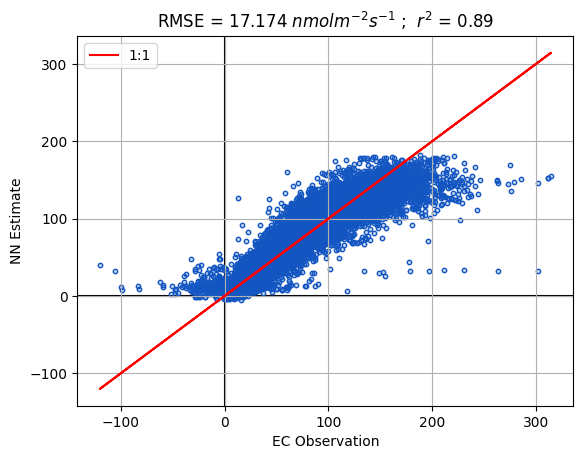

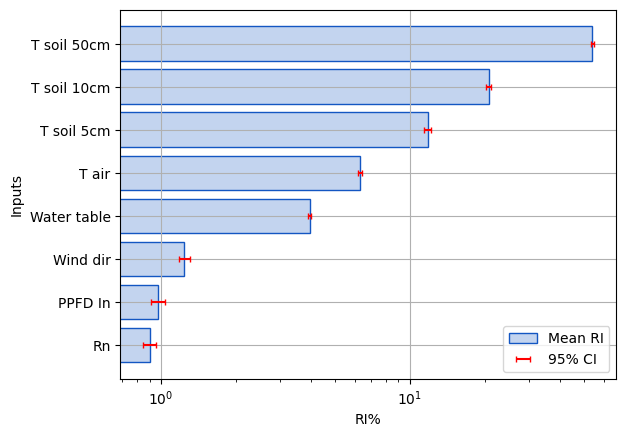

In [261]:
importlib.reload(PlotHelpers)
importlib.reload(NNetFuncs)

key = 'Final_Model_FCH4'

config = Model_Runs[key]['config']
Eval = Model_Runs[key]['Training']
full_out=NNetFuncs.run_Model(config,Eval)
# print('\n\n')

Base = Model_Runs[key]['config']['Base']
Name = Model_Runs[key]['config']['Name']

# run = 'Feature_Detection'
if config['Base']=='FCH4':
    unit = '$nmol m^{-2} s^{-1}$'

else:
    unit = '$\mu mol m^{-2} s^{-1}$'

df = pd.read_csv(f'Models/{Base}/{Name}/model_output.csv',index_col=[0])

fig,ax=plt.subplots()
ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
ax.set_ylabel('NN Estimate')
ax.set_xlabel('EC Observation')
 
RI = pd.read_csv(f'Models/{Base}/{Name}/model_RI.csv',index_col=[0])

RI = RI.sort_values(by=f'RI_bar',ascending=True)
fig,ax=plt.subplots()
PlotHelpers.makeRI_plot(ax,RI)

print(RI.round(2))


In [160]:

Eval = Model_Runs[key]['Training']
Eval['X'].shape

(19601, 8)

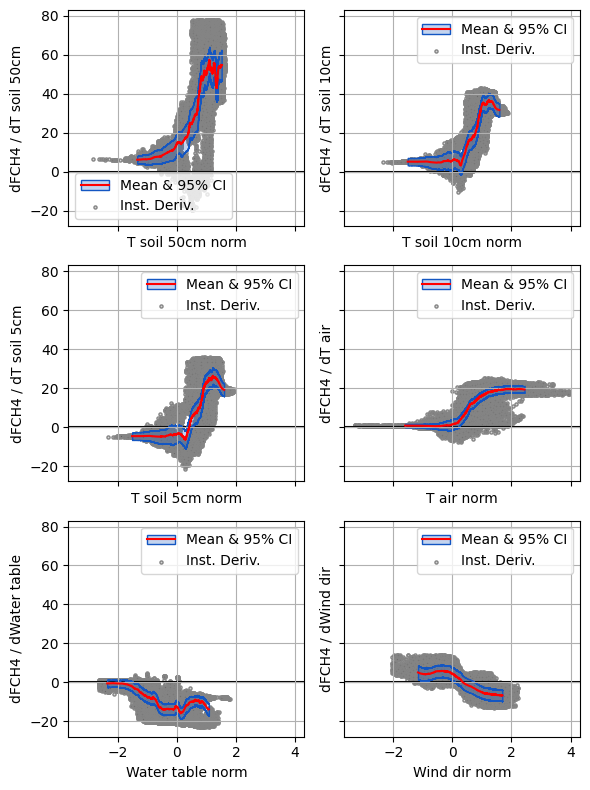

In [289]:
importlib.reload(PlotHelpers)
importlib.reload(MiscFuncs)

Max=6
Top = list(RI.sort_values(by=f'RI_bar',ascending=False).index)

exclude = ['HR']
for ex in exclude:
    try:
        Top.remove(ex)
    except:
        pass

Top = Top[:Max]

cols = 2
npi=len(RI.index)
rows = int(np.ceil(len(Top)/2))

fig,axes=plt.subplots(rows,cols,sharey=True,sharex=True,
                      figsize=(6,8))

axes = axes.flatten()

mod = '_norm'

for i,xi in enumerate(Top):
    # print(xi)
    # df_int = MiscFuncs.byInterval(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],bins=25)
    # print(df.columns)
    df_int = MiscFuncs.rolling(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],[f'dy_d{xi}{mod}_Var'],n=20)
    pt = axes[i].scatter(df[f'{xi}{mod}'],df[f'dy_d{xi}{mod}'],facecolor='#5e5d5d40',edgecolor='#858585',s=5)
    _,patch,label = PlotHelpers.CI_Plot(axes[i],df_int,f'dy_d{xi}{mod}',ci=f'dy_d{xi}{mod}_Var')
    label.append('Inst. Deriv.')
    patch.append(pt)
    axes[i].legend(patch,label)
plt.tight_layout()
axes[i].get_ylabel()

for ax in axes:
    l = ax.get_ylabel().split('_norm')[0]
    ax.set_ylabel(l.replace('_',' / ').replace('y',config['Base']))
    ax.set_xlabel(l.split('_d')[-1]+' '+mod.split('_')[-1])
    plt.tight_layout()


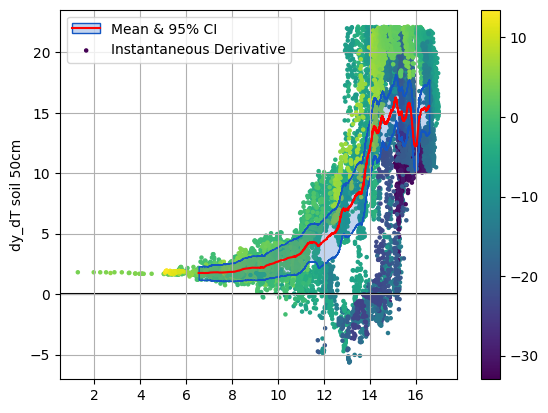

In [288]:
fig,ax=plt.subplots()
xi='T soil 50cm'
mod = ''
x2 = 'Water table'
df_int = MiscFuncs.rolling(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],[f'dy_d{xi}{mod}_Var'],n=20)
pt = ax.scatter(df[f'{xi}{mod}'],df[f'dy_d{xi}{mod}'],c=df[f'{x2}{mod}'],s=5)#,edgecolor='#858585'
plt.colorbar(pt)
_,patch,label = PlotHelpers.CI_Plot(ax,df_int,f'dy_d{xi}{mod}',ci=f'dy_d{xi}{mod}_Var')
label.append('Instantaneous Derivative')
patch.append(pt)
ax.legend(patch,label)

1960


<Axes: ylabel='dy_dWater table'>

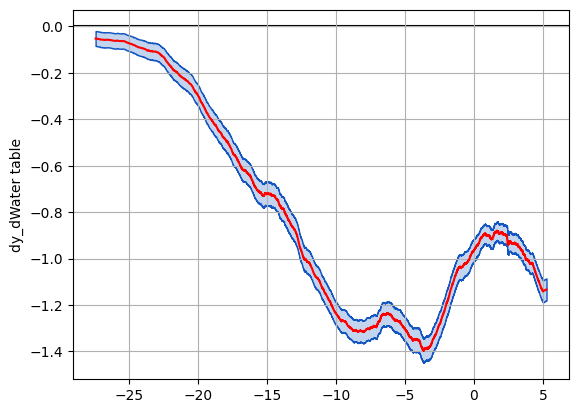

In [188]:
Top
xi = Top[0]
xi = 'Water table'
# MiscFuncs.byInterval(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],bins=100)
Temp = df.copy()
nr = int(Temp.shape[0]/10)
print(nr)
Srt_m = Temp.sort_values(by=f'{xi}{mod}')[[f'{xi}{mod}',f'dy_d{xi}{mod}']].rolling(nr).mean()
Srt_m[f'dy_d{xi}{mod}_CI95'] = Temp.sort_values(by=f'{xi}{mod}')[[f'{xi}{mod}',f'dy_d{xi}{mod}_CI95']].rolling(nr).mean()[[f'dy_d{xi}{mod}_CI95']]
Srt_m = Srt_m.set_index(f'{xi}{mod}')
# Temp = Temp.sort_values(by=f'{xi}{mod}')[[f'{xi}{mod}',f'dy_d{xi}{mod}']]
# Temp = Temp.loc[(Temp[f'{xi}{mod}']-9).abs()<.25]
# plt.figure()
# plt.plot(Srt_m[f'{xi}{mod}'],Srt_m[f'dy_d{xi}{mod}'])
# # plt.plot(Srt_m[f'{xi}{mod}'],Srt_m[f'dy_d{xi}{mod}'])
# Temp[[f'{xi}{mod}',f'dy_d{xi}{mod}',f'dy_d{xi}{mod}_CI95']]#.shape

fig,ax=plt.subplots()

PlotHelpers.CI_Plot(ax,Srt_m,f'dy_d{xi}{mod}')
# Temp[f'{xi}{mod}'].hist(ax=ax)

# df_int = MiscFuncs.byInterval(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],bins=100)
# df_int


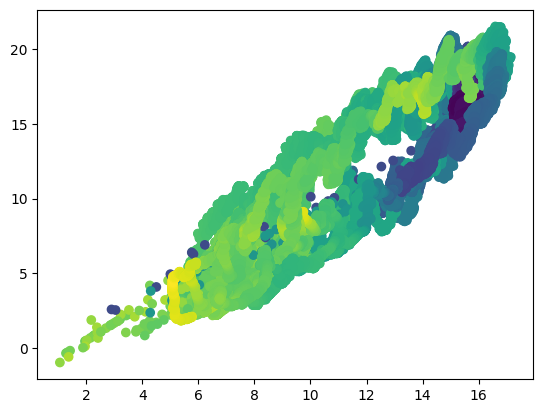

In [293]:
fig,ax=plt.subplots()
ax.scatter(Data['T soil 50cm'],Data['T soil 5cm'],c=Data['Water table'])

In [124]:

# df = pd.read_csv(f'Models/{run}/random_forest_output.csv',index_col=[0])

# unit = ''

# fig,ax=plt.subplots()
# ax.scatter(df['target'],df['y_bar'])
# ax.plot(df['target'],df['target'],color='k')
# r2 = np.round(metrics.r2_score(df['target'],df['y_bar']),2)
# RMSE = np.round(metrics.mean_squared_error(df['target'],df['y_bar'])**.5,2)
# ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
# ax.set_ylabel('NN Estimate')
# ax.set_xlabel('EC Observation')

# RF_RI = pd.read_csv(f'Models/{run}/random_forest_RI.csv',index_col=[0])

# mod = ''

# RF_RI = RF_RI.sort_values(by = f'RI{mod}_bar')

# fig,ax=plt.subplots()
# ax.barh(RF_RI.index,RF_RI[f'RI{mod}_bar'],xerr=RF_RI[f'RI{mod}_CI95'])
# ax.grid()
# ax.set_xscale('log')

# RF_RI

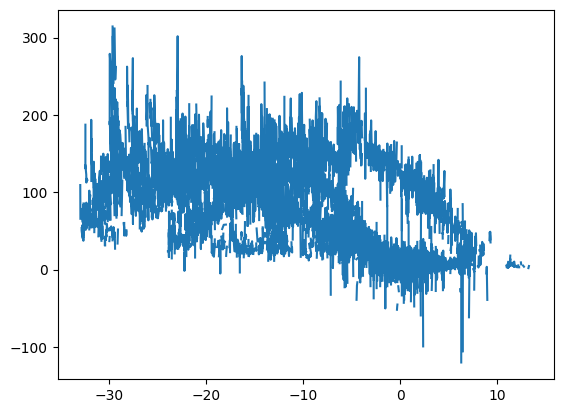

In [193]:
X = np.arange(-10,10)
Y = X**2

fig,ax=plt.subplots()
# ax.plot(X[1:],np.diff(Y))
# ax.plot(X[1:],Y[1:])
ax.plot(Data['Water table'],Data['FCH4_Clean'])